# Fitting Random Forest Model and Model Performance #

In [1]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("max_columns", 100)
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


In [2]:
# Read in data
combined = pd.read_csv("data/combined1.csv")

In [3]:
combined.dtypes

female              int64
callback            int64
skillspeaking     float64
skillsocialper    float64
east_asian          int64
south_asian         int64
anglo               int64
vancouver           int64
toronto             int64
montreal            int64
dtype: object

In [4]:
combined['callback'].value_counts()

0    11612
1     1281
Name: callback, dtype: int64

In [5]:
# Use SMOTE to oversample the callback = 1
oversample = SMOTE()
y = combined['callback']
X = combined.drop(['callback'], axis=1)
X, y = oversample.fit_resample(X,y)

In [6]:
y.value_counts()

1    11612
0    11612
Name: callback, dtype: int64

My data-set is imbalanced with respect to the classification outcome. In order to properly predict the minory classification (callback = 1), I decided to use the SMOTE oversampling technique.

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

["Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found. A randomly selected neighbor is chosen and a artificial example is created at a randomly selected point between the two examples in feature space."](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

This procedure can be used to create as many synthetic plausible examples for the minority class that are required.

In [7]:
# Count number of sample for binary variable

counter = Counter(y)
for k, v in counter.items():
    dist = v / len(y) * 100
    print(f"Class = {k}, n ={v} ({dist}%)")

Class = 0, n =11612 (50.0%)
Class = 1, n =11612 (50.0%)


### Preprocessing Data - Combined Data ###

In [8]:
# Train test split and use skfold
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
skfold = StratifiedKFold(n_splits=5, shuffle=True)

The train-test split is a necessity for supervised learning models. The objective of these supervised learning models is to create a model that can take in new data and accurately predict the inputs and outputs of the new data. To do this, supervised learning models use available data to fit and evaluate the accuracy of the known inputs and ouputs. However if we use just the available data to build the model and evaluate it, the model will just predict the right output for any observation and does not indicate whether the model can generalize well.

In stratified cross-validation, we split the data such that the proportions between variables are the same in each fold as represented by the whole data-set.

To give an example, if 90% of your samples belong to class A and 10% of your samples belong to class B, then stratified cross-validation ensures that in each fold, 90% of samples belong to class A and 10% of samples belong to class B.

This is different than in regular k-fold cross-valudation as there is a possibility that one fold may contain all samples of a certain class. Using this fold as a test set would not be very informative about the overall performance of the model.

Stratified k-fold cross-validation is generally better used instead of k-fold cross-validation to evaluate a classifier because it has better generalizability and performance.

In [9]:
# use the select from model with RFC to test what features are important besides the necessary ones (dependent on weights)
sel = SelectFromModel(RandomForestClassifier(n_estimators=500, max_features = 'sqrt', criterion= 'entropy'))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(criterion='entropy',
                                                 max_features='sqrt',
                                                 n_estimators=500))

SelectFromModel from Scikit-Learn is based on a Machine Learning Model estimation for selecting the features. The differences are that SelectFromModel feature selection is based on the importance attribute (often is coef_ or feature_importances_ but it could be any callable) threshold. By default, the threshold is the mean.

In [10]:
# print selected features
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['skillspeaking', 'skillsocialper'], dtype='object')


From the select from model algorithim, I wanted to inspect again the features that are the mot important when fitting the X train and y train models. As mentioned the skill speaking and the skill social variables seem to have an influence on the call back variable.

In [16]:
# Fitting the RF model
rforest =  RandomForestClassifier()
rforest.fit(X_train,y_train)
ypred = rforest.predict(X_test)

In [17]:
# Print out results
print("RANDOM FOREST")
print("Training set score: {:.2f}".format(rforest.score(X_train, y_train)))
print("Test set score: {:.2f}".format(rforest.score(X_test, y_test)))

print("Mean Cross Validation, SKFold: {:.2f}".format(np.mean(cross_val_score(rforest, 
                                                                             X_train, 
                                                                             y_train, 
                                                                             cv=skfold,
                                                                            scoring = 'accuracy'))))

rforest_feature = pd.DataFrame(data=rforest.feature_importances_).T
rforest_feature.columns = X.columns
rforest_feature.index=['Random Forest Features']

RANDOM FOREST
Training set score: 0.78
Test set score: 0.76
Mean Cross Validation, SKFold: 0.76


In [20]:
# Random Forest Feature Importance
rforest_feature

,female,skillspeaking,skillsocialper,east_asian,south_asian,anglo,vancouver,toronto,montreal
Random Forest Features,0.045939,0.297429,0.282649,0.067126,0.073859,0.055427,0.053533,0.068563,0.055476


In [18]:
#Grid Search CV for RF model
param_grid = { 
     'n_estimators': [100, 200, 500],
     'max_features': ['auto', 'sqrt', 'log2'],
     'criterion' :['gini', 'entropy']}

In [19]:
CV_rfc = GridSearchCV(estimator=rforest, param_grid=param_grid, cv= skfold)
CV_rfc.fit(X_train, y_train)
print("Best Parameter: {}".format(CV_rfc.best_params_))

Best Parameter: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100}


Hyperparameter is a characteristic of a model that is external to the model and whose value cannot be estimated from data. Therefore, I will use GridSearchCV to iteratively look over chosen hyper parameters to decide which has the best model fit for the random forest model.

### Fitting Data ###

In [21]:
# Fitting the RF model with Grid Search Parameters
rforest_grid =  RandomForestClassifier(n_estimators=100, max_features = 'log2', criterion= 'entropy')
rforest_grid.fit(X_train,y_train)
ypred = rforest_grid.predict(X_test)

100 Estimators: Number of Trees

Max Features: Max number of features for splitting a node

Criterion: Entropy - Measurement of error

In [22]:
# Print out results
print("RANDOM FOREST - Grid Search")
print("Training set score: {:.2f}".format(rforest_grid.score(X_train, y_train)))
print("Test set score: {:.2f}".format(rforest_grid.score(X_test, y_test)))

print("Mean Cross Validation, SKFold: {:.2f}".format(np.mean(cross_val_score(rforest_grid, 
                                                                             X_train, 
                                                                             y_train, 
                                                                             cv=skfold,
                                                                            scoring = 'accuracy'))))

rforest_feature = pd.DataFrame(data=rforest_grid.feature_importances_).T
rforest_feature.columns = X.columns
rforest_feature.index=['Random Forest Features']

RANDOM FOREST - Grid Search
Training set score: 0.78
Test set score: 0.76
Mean Cross Validation, SKFold: 0.75


Random Forest consists of a large number of decision trees and works as an ensemble technique. Random Forests works on the principle of bagging, wherein each decision tree is built on a sample of the training data set with replacement. The results from these multiple decision trees are then aggregated to come up with the final forecast. For the purposes of classification, the mode of all the predictions is used. 

- Works well with multiple features
- Works well with linear or non-linear relationships
- Balances bias and variance trade-off

In [23]:
# Random Forest Feature Importance - Grid Search
rforest_feature

,female,skillspeaking,skillsocialper,east_asian,south_asian,anglo,vancouver,toronto,montreal
Random Forest Features,0.045701,0.299531,0.292071,0.061935,0.062256,0.055183,0.060021,0.062348,0.060954


In [24]:
print(metrics.classification_report(ypred, y_test))

              precision    recall  f1-score   support

           0       0.75      0.76      0.76      2892
           1       0.76      0.75      0.76      2914

    accuracy                           0.76      5806
   macro avg       0.76      0.76      0.76      5806
weighted avg       0.76      0.76      0.76      5806



F1 score: For a use case that requires a balance between precision and recall, the F1 score is used. F1 score is the harmonic mean of precision and recall values. It punishes extreme values more to keep the balance.

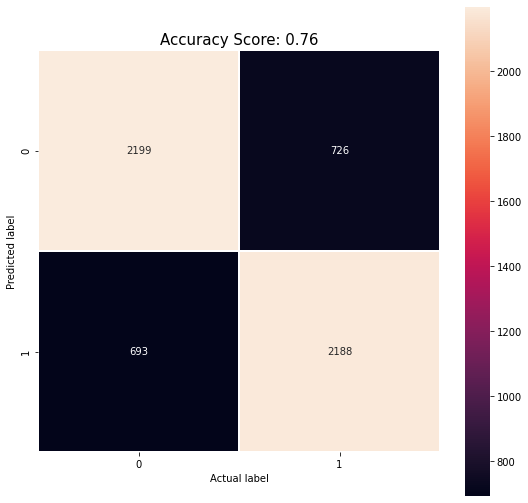

In [25]:
rf_mat = metrics.confusion_matrix(y_test, ypred)
plt.figure(figsize=(9,9))
score = (rforest_grid.score(X_test, y_test))
sns.heatmap(rf_mat, annot=True, fmt=".0f", linewidths=.5, square = True);
plt.xlabel('Actual label');
plt.ylabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(score, 2))
plt.title(all_sample_title, size = 15);

In [26]:
combined.head(10)

,female,callback,skillspeaking,skillsocialper,east_asian,south_asian,anglo,vancouver,toronto,montreal
0,1,0,54.901961,31.25,0,0,1,0,1,0
1,0,0,54.901961,31.25,0,1,0,0,1,0
2,0,0,54.901961,31.25,0,1,0,0,1,0
3,0,0,54.901961,31.25,1,0,0,0,1,0
4,1,0,74.509804,62.50,0,1,0,0,1,0
5,0,0,74.509804,62.50,0,0,1,0,1,0
6,0,0,74.509804,62.50,1,0,0,0,1,0
7,0,0,74.509804,62.50,0,1,0,0,1,0
8,1,1,54.901961,31.25,0,0,0,0,1,0
9,1,1,54.901961,31.25,0,1,0,0,1,0


### Testing on User input data ###

In [80]:
X_check = pd.DataFrame([[1, 70, 50, 0, 1, 0, 0, 1, 0],
                    [1, 80, 40, 0, 0, 1, 0, 0, 1],
                    [1, 20, 30, 1, 0, 0, 1, 0, 0]], 
                    columns=['female', 'skillspeaking', 'skillsocialper', 
                   'east_asian', 'south_asian','anglo', 'vancouver',
                   'toronto', 'montreal'])

In [81]:
X_check

,female,skillspeaking,skillsocialper,east_asian,south_asian,anglo,vancouver,toronto,montreal
0,1,70,50,0,1,0,0,1,0
1,1,80,40,0,0,1,0,0,1
2,1,20,30,1,0,0,1,0,0


In [142]:
y_check = rforest_grid.predict(X_check)
# Confidence
y_pred_prob = rforest_grid.predict_proba(X_check)


In [134]:
user_output = np.array(y_check)
user_output = user_output.reshape(-1, 3)
pred_pro  = np.array(y_pred_prob).T

In [141]:
output = pd.DataFrame(np.concatenate((user_output, pred_pro))).transpose()

output.rename(columns={0: 'Callback', 1: 'Prob_O', 2: 'Prob_1'})

,Callback,Prob_O,Prob_1
0,0.0,0.980605,0.019395
1,0.0,0.852427,0.147573
2,0.0,0.724041,0.275959


### Save to Pickle and Double Check Fit Model ###

In [ ]:
import pickle

In [ ]:
data = {'model': rforest_grid}
with open ('saved_steps.pkl', 'wb') as file:
    pickle.dump(data,file)

In [ ]:
with open('saved_steps.pkl', 'rb') as file:
    data = pickle.load(file)

In [ ]:
rforest_loaded = data['model']

In [ ]:
y_pred_check = rforest_loaded.predict(X_test)

In [103]:
y_pred_check[0:11]

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0])